In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import kagglehub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
)
from sklearn.preprocessing import label_binarize


In [23]:
path=kagglehub.dataset_download("alsaniipe/flowers-multiclass-datasets")
path

'/kaggle/input/flowers-multiclass-datasets'

In [24]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        #  std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

In [25]:
root_dir = path + "/flowers/flowers/flower_photos"

train_dataset = datasets.ImageFolder(root=f"{root_dir}/train", transform=train_transform)
val_dataset   = datasets.ImageFolder(root=f"{root_dir}/validation", transform=eval_transform)
test_dataset  = datasets.ImageFolder(root=f"{root_dir}/test", transform=eval_transform)

print("Train:", len(train_dataset))
print("Validation:", len(val_dataset))
print("Test:", len(test_dataset))
print("Classes:", train_dataset.classes)

Train: 3540
Validation: 80
Test: 50
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [26]:
print(train_dataset.class_to_idx)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [27]:
img, label = train_dataset[0]
print(img.shape)
print(label)

torch.Size([3, 224, 224])
0


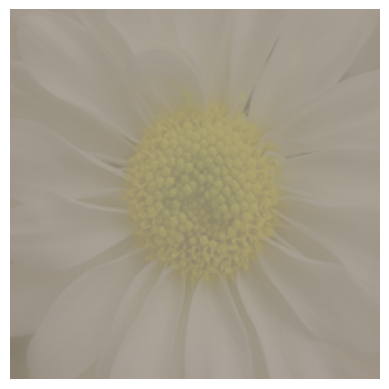

In [28]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

for img, label in train_dataset:
    imshow(img)
    break


In [29]:
def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, device, num_epochs=10):
    best_val_acc = 0
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        model.eval()
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for val_images, val_labels_batch in val_loader:
                val_images, val_labels_batch = val_images.to(device), val_labels_batch.to(device)
                val_outputs = model(val_images)
                _, val_pred = torch.max(val_outputs, 1)
                val_preds.extend(val_pred.cpu().numpy())
                val_labels.extend(val_labels_batch.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)

    model.eval()
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for test_images, test_labels_batch in test_loader:
            test_images, test_labels_batch = test_images.to(device), test_labels_batch.to(device)
            test_outputs = model(test_images)
            _, test_pred = torch.max(test_outputs, 1)
            test_preds.extend(test_pred.cpu().numpy())
            test_labels.extend(test_labels_batch.cpu().numpy())



In [30]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

Metrics & Visualizations

In [31]:
def compute_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return accuracy, precision, recall, f1, all_labels, all_preds


In [32]:
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


In [33]:
def plot_roc_auc(model, dataloader, device, class_names):
    model.eval()
    true_labels = []
    probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            softmax_probs = torch.softmax(outputs, dim=1)
            probs.extend(softmax_probs.cpu().numpy())
            true_labels.extend(labels.numpy())

    true_labels = np.array(true_labels)
    probs = np.array(probs)
    true_bin = label_binarize(true_labels, classes=range(len(class_names)))

    plt.figure(figsize=(10,8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(true_bin[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.legend(loc='lower right')
    plt.show()


VGGNet Model

In [34]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=5):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),  # 112x112
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), # 56x56
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),# 28x28
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),# 14x14
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2) # 7x7
        )
        self.classifier = nn.Sequential(
            nn.Linear(256*7*7, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [35]:
model = VGGNet(num_classes=len(train_dataset.classes)).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, device, num_epochs=10)


Epoch 1/10 - Train Loss: 1.4680, Train Acc: 0.3483, Val Acc: 0.4500
Epoch 2/10 - Train Loss: 1.1857, Train Acc: 0.4946, Val Acc: 0.5375
Epoch 3/10 - Train Loss: 1.1178, Train Acc: 0.5322, Val Acc: 0.6375
Epoch 4/10 - Train Loss: 1.0490, Train Acc: 0.5624, Val Acc: 0.6250
Epoch 5/10 - Train Loss: 0.9869, Train Acc: 0.6062, Val Acc: 0.7000
Epoch 6/10 - Train Loss: 0.9267, Train Acc: 0.6452, Val Acc: 0.6625
Epoch 7/10 - Train Loss: 0.8424, Train Acc: 0.6831, Val Acc: 0.7125
Epoch 8/10 - Train Loss: 0.7789, Train Acc: 0.7138, Val Acc: 0.7000
Epoch 9/10 - Train Loss: 0.7551, Train Acc: 0.7201, Val Acc: 0.6875
Epoch 10/10 - Train Loss: 0.7245, Train Acc: 0.7268, Val Acc: 0.6750


Model Accuracy: 0.6000, Precision: 0.5531, Recall: 0.6000, F1: 0.5624


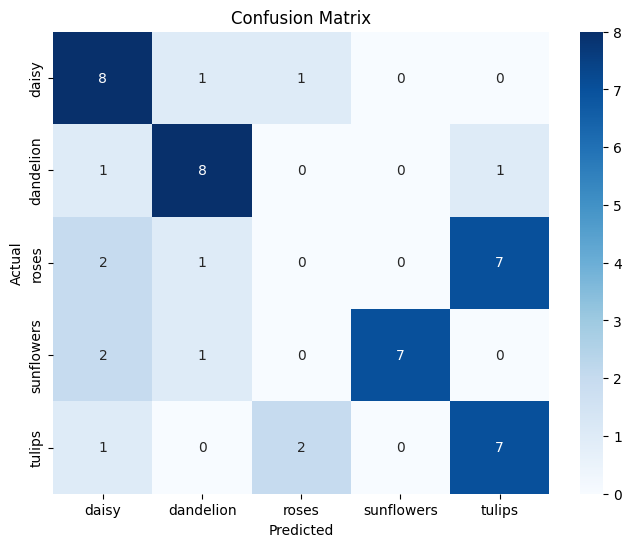

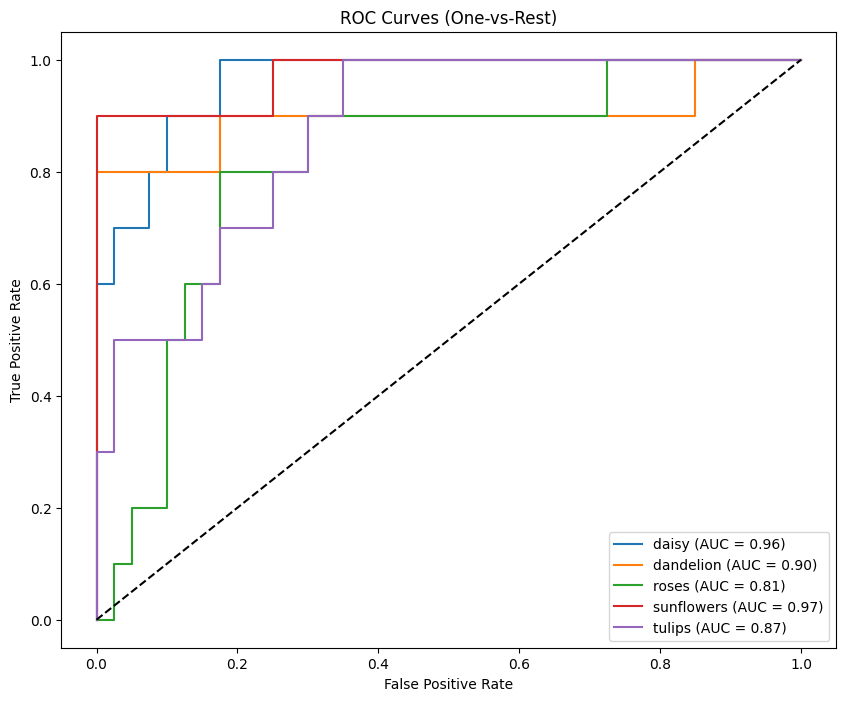

In [36]:
acc, prec, rec, f1, true, pred = compute_metrics(model, test_loader, device)
print(f"Model Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

plot_confusion_matrix(true, pred, test_dataset.classes)

plot_roc_auc(model, test_loader, device, test_dataset.classes)


Pre Trained Model

In [37]:
num_classes = len(train_dataset.classes)

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Freeze Base, Train Head

In [38]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [39]:
train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, device, num_epochs=10)

Epoch 1/10 - Train Loss: 0.7313, Train Acc: 0.7395, Val Acc: 0.8375
Epoch 2/10 - Train Loss: 0.4178, Train Acc: 0.8582, Val Acc: 0.8250
Epoch 3/10 - Train Loss: 0.3237, Train Acc: 0.8921, Val Acc: 0.8500
Epoch 4/10 - Train Loss: 0.3009, Train Acc: 0.8960, Val Acc: 0.9000
Epoch 5/10 - Train Loss: 0.2962, Train Acc: 0.8932, Val Acc: 0.8625
Epoch 6/10 - Train Loss: 0.2608, Train Acc: 0.9085, Val Acc: 0.8375
Epoch 7/10 - Train Loss: 0.2522, Train Acc: 0.9105, Val Acc: 0.9125
Epoch 8/10 - Train Loss: 0.2411, Train Acc: 0.9178, Val Acc: 0.9125
Epoch 9/10 - Train Loss: 0.2381, Train Acc: 0.9178, Val Acc: 0.8875
Epoch 10/10 - Train Loss: 0.2332, Train Acc: 0.9186, Val Acc: 0.8750


Model Accuracy: 0.8600, Precision: 0.8639, Recall: 0.8600, F1: 0.8560


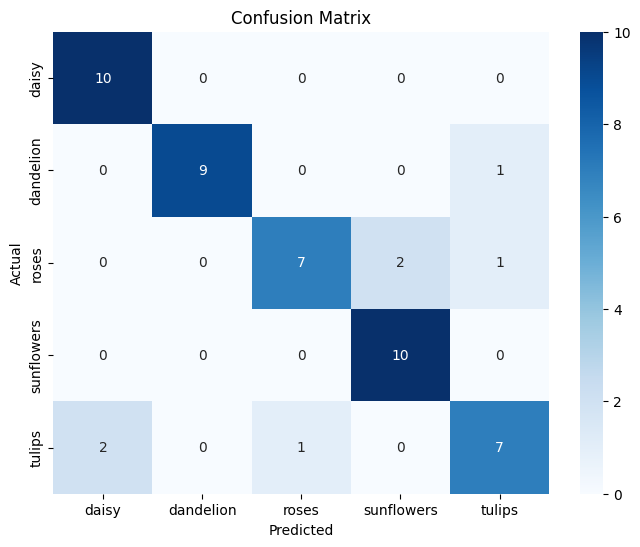

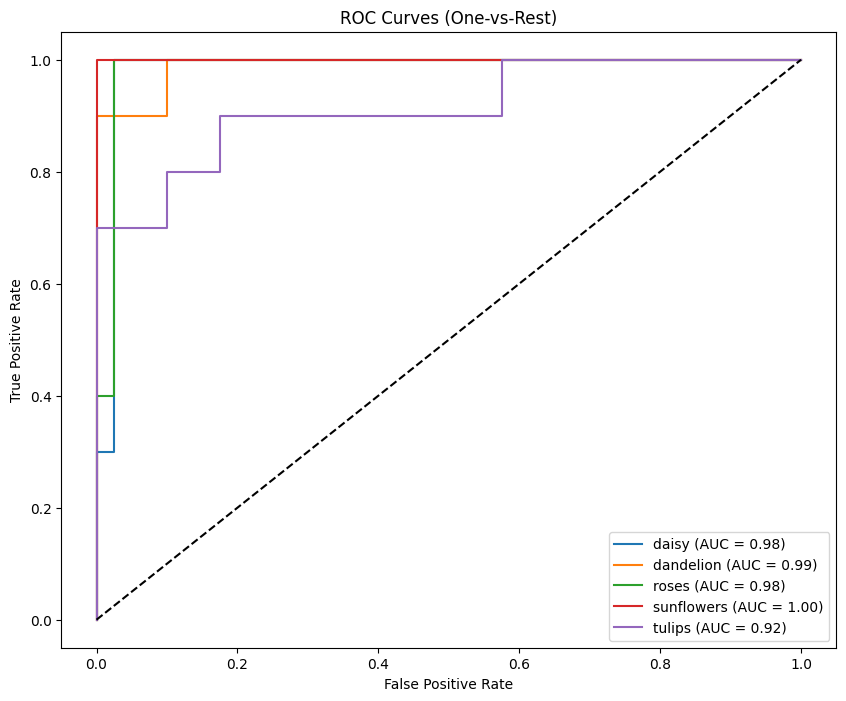

In [40]:
acc, prec, rec, f1, true, pred = compute_metrics(model, test_loader, device)
print(f"Model Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

plot_confusion_matrix(true, pred, test_dataset.classes)

plot_roc_auc(model, test_loader, device, test_dataset.classes)


Unfreeze Last Conv Layer

In [41]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [42]:
train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, device, num_epochs=10)

Epoch 1/10 - Train Loss: 0.2248, Train Acc: 0.9172, Val Acc: 0.8125
Epoch 2/10 - Train Loss: 0.2357, Train Acc: 0.9133, Val Acc: 0.8625
Epoch 3/10 - Train Loss: 0.2274, Train Acc: 0.9186, Val Acc: 0.8375
Epoch 4/10 - Train Loss: 0.2089, Train Acc: 0.9237, Val Acc: 0.9000
Epoch 5/10 - Train Loss: 0.2004, Train Acc: 0.9251, Val Acc: 0.8750
Epoch 6/10 - Train Loss: 0.1946, Train Acc: 0.9282, Val Acc: 0.9000
Epoch 7/10 - Train Loss: 0.1824, Train Acc: 0.9350, Val Acc: 0.9375
Epoch 8/10 - Train Loss: 0.1931, Train Acc: 0.9288, Val Acc: 0.8875
Epoch 9/10 - Train Loss: 0.1733, Train Acc: 0.9356, Val Acc: 0.8875
Epoch 10/10 - Train Loss: 0.1773, Train Acc: 0.9379, Val Acc: 0.8875


Model Accuracy: 0.8600, Precision: 0.8702, Recall: 0.8600, F1: 0.8610


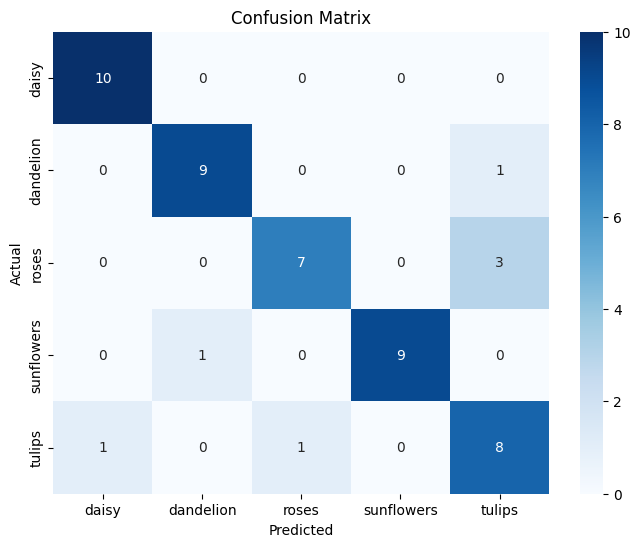

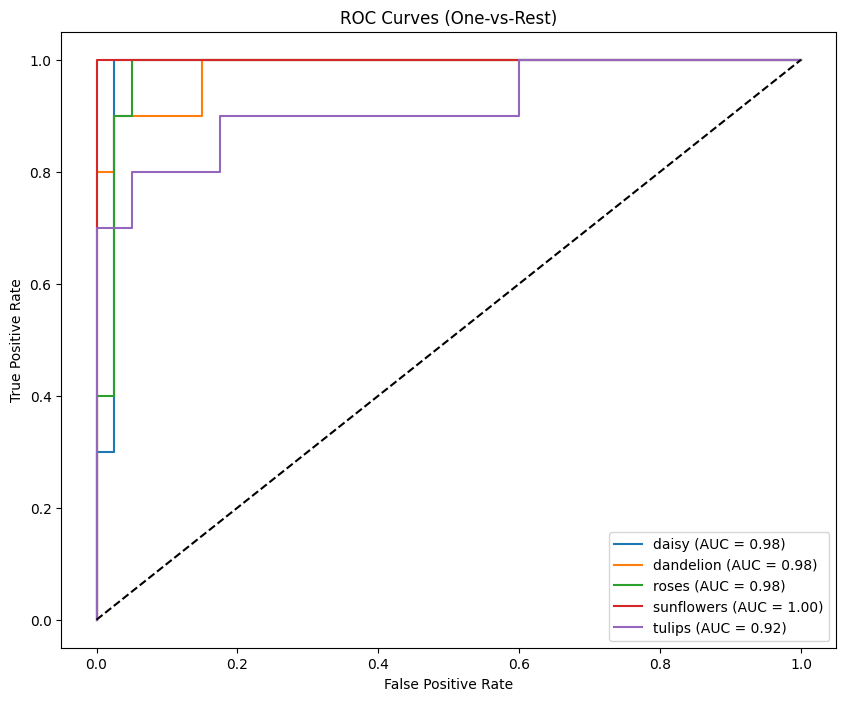

In [43]:
acc, prec, rec, f1, true, pred = compute_metrics(model, test_loader, device)
print(f"Model Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

plot_confusion_matrix(true, pred, test_dataset.classes)

plot_roc_auc(model, test_loader, device, test_dataset.classes)


Unfreeze Last Conv Layer

In [44]:
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001
)


In [45]:
train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, device, num_epochs=10)

Epoch 1/10 - Train Loss: 0.2661, Train Acc: 0.9102, Val Acc: 0.8875
Epoch 2/10 - Train Loss: 0.0773, Train Acc: 0.9763, Val Acc: 0.8875
Epoch 3/10 - Train Loss: 0.0301, Train Acc: 0.9910, Val Acc: 0.9625
Epoch 4/10 - Train Loss: 0.0247, Train Acc: 0.9932, Val Acc: 0.9000
Epoch 5/10 - Train Loss: 0.0245, Train Acc: 0.9924, Val Acc: 0.9375
Epoch 6/10 - Train Loss: 0.0167, Train Acc: 0.9955, Val Acc: 0.9625
Epoch 7/10 - Train Loss: 0.0392, Train Acc: 0.9881, Val Acc: 0.9250
Epoch 8/10 - Train Loss: 0.0527, Train Acc: 0.9811, Val Acc: 0.9125
Epoch 9/10 - Train Loss: 0.0324, Train Acc: 0.9887, Val Acc: 0.9125
Epoch 10/10 - Train Loss: 0.0318, Train Acc: 0.9910, Val Acc: 0.9125


Model Accuracy: 0.8800, Precision: 0.8818, Recall: 0.8800, F1: 0.8799


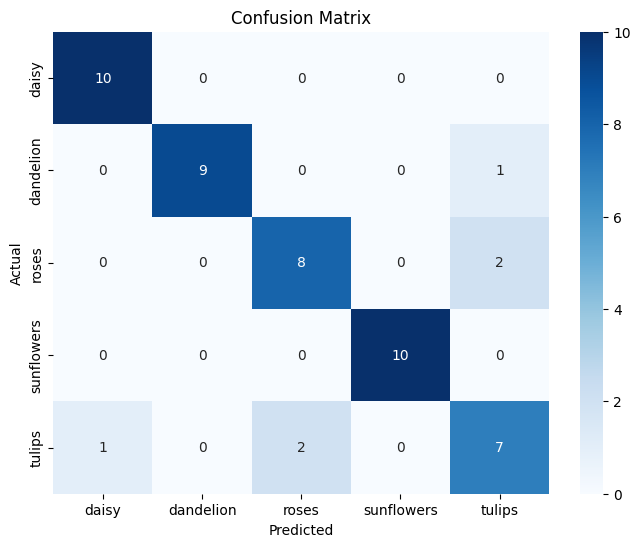

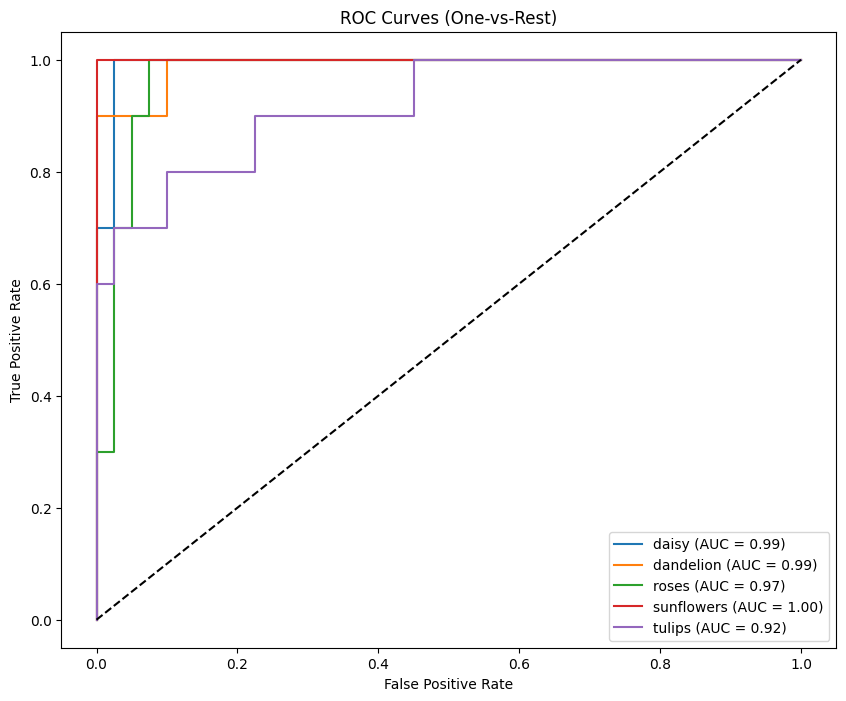

In [46]:
acc, prec, rec, f1, true, pred = compute_metrics(model, test_loader, device)
print(f"Model Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

plot_confusion_matrix(true, pred, test_dataset.classes)

plot_roc_auc(model, test_loader, device, test_dataset.classes)


Unfreeze All

In [47]:
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)


In [48]:
train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, device, num_epochs=10)

Epoch 1/10 - Train Loss: 0.0084, Train Acc: 0.9980, Val Acc: 0.9375
Epoch 2/10 - Train Loss: 0.0026, Train Acc: 0.9994, Val Acc: 0.9500
Epoch 3/10 - Train Loss: 0.0020, Train Acc: 0.9992, Val Acc: 0.9250
Epoch 4/10 - Train Loss: 0.0035, Train Acc: 0.9983, Val Acc: 0.9375
Epoch 5/10 - Train Loss: 0.0023, Train Acc: 0.9992, Val Acc: 0.9625
Epoch 6/10 - Train Loss: 0.0022, Train Acc: 0.9994, Val Acc: 0.9375
Epoch 7/10 - Train Loss: 0.0013, Train Acc: 0.9994, Val Acc: 0.9500
Epoch 8/10 - Train Loss: 0.0013, Train Acc: 0.9997, Val Acc: 0.9500
Epoch 9/10 - Train Loss: 0.0007, Train Acc: 1.0000, Val Acc: 0.9500
Epoch 10/10 - Train Loss: 0.0024, Train Acc: 0.9994, Val Acc: 0.9500


Model Accuracy: 0.9000, Precision: 0.9051, Recall: 0.9000, F1: 0.9008


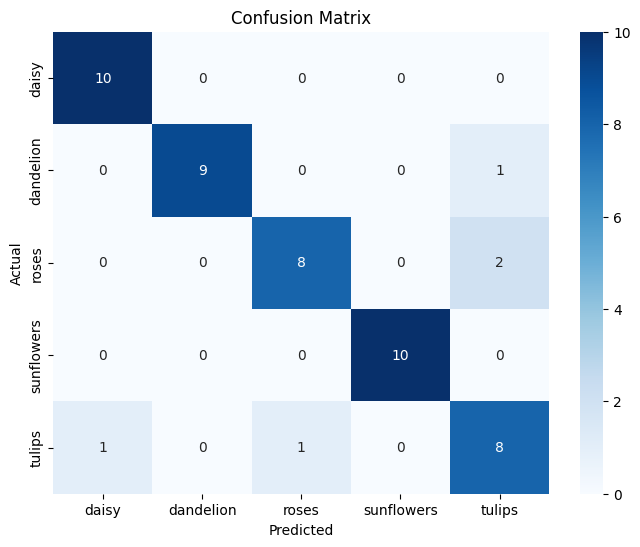

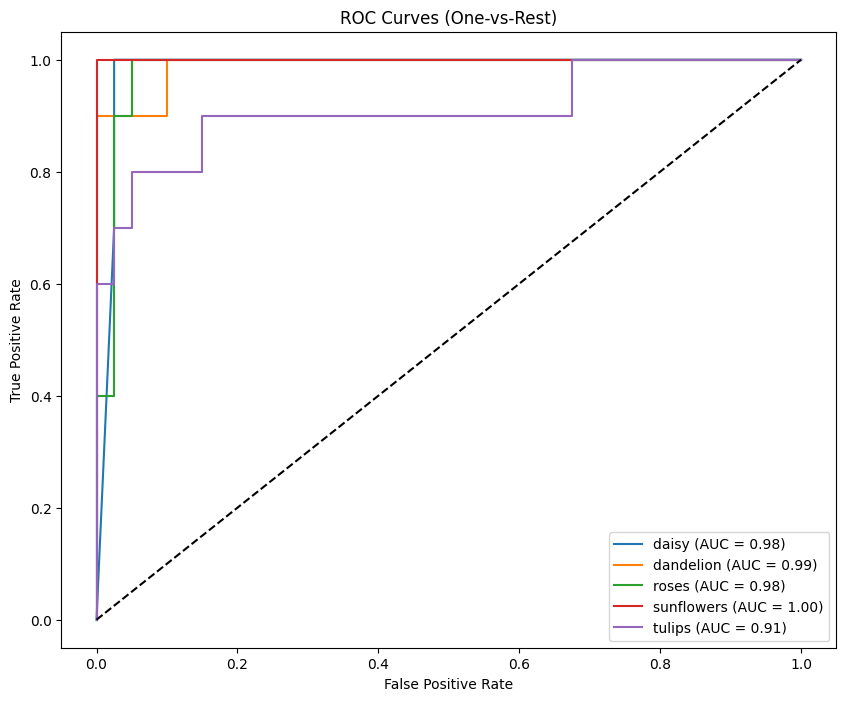

In [49]:
acc, prec, rec, f1, true, pred = compute_metrics(model, test_loader, device)
print(f"Model Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

plot_confusion_matrix(true, pred, test_dataset.classes)

plot_roc_auc(model, test_loader, device, test_dataset.classes)
